In [1]:
from dataset_descriptor import DatasetDescriptor, get_dataloader
from net_FC import NetFC
from loss import ContrastiveLoss

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 250
learning_rate = 1e-3
batch_size = 50

data_all = DatasetDescriptor('data_descriptors.py.npy', 'labels.py.npy', transform_strength=3e-4)
dataset_train, dataset_valid = data_all.generate_train_validation_split()

train_loader = get_dataloader(dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = get_dataloader(dataset_valid, batch_size=batch_size, shuffle=False)
cluster_loader = get_dataloader(data_all, batch_size=batch_size, shuffle=True)
cluster_loader_viz = get_dataloader(data_all, batch_size=batch_size, shuffle=False)

layers = [1080, 1080, 1080, 64]

## Train classification

In [ ]:
accuracy_train = np.zeros(n_epochs)
accuracy_valid = np.zeros(n_epochs)

loss = F.cross_entropy
n_classes = 10
model = NetFC(layers, n_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.75)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

for n in range(n_epochs):
    
    model.train()
    for i, blob in enumerate(train_loader):
        #print(f"\rEpoch {n}: Progress: {round(100 * i / len(loader), 2)} %", end='')
        optimizer.zero_grad()

        data, targets = [x.to(device).float() for x in blob]
        predictions = model(data)
        l = loss(predictions, targets)
        l.backward()

        optimizer.step()
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        N = 0
        C = 0
        for i, blob in enumerate(train_loader):
            data, targets = [x.to(device=device).float() for x in blob]
            predictions = model(data)
            C += torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(targets, dim=1))
            N += predictions.shape[0]

        #print(f"Epoch {str(n).rjust(4)} TRAIN| Accuracy: {round(100 * C.cpu().item() / N, 2)}%")
        accuracy_train[n] = 100 * C / N

        N = 0
        C = 0
        for i, blob in enumerate(valid_loader):
            data, targets = [x.to(device=device).float() for x in blob]
            predictions = model(data)
            C += torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(targets, dim=1))
            N += predictions.shape[0]

        #print(f"Epoch {str(n).rjust(4)} VALID| Accuracy: {round(100 * C.cpu().item() / N, 2)}%")
        accuracy_valid[n] = 100 * C / N

In [ ]:
plt.figure()
plt.plot(accuracy_train)
plt.plot(accuracy_valid)
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Training / validation dataset accuracy w.r.t. number of epochs')
plt.show()

## Train cluster

In [4]:
loss = ContrastiveLoss()
n_classes = 2
model = NetFC(layers, n_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

D = []
L = []

for n in range(n_epochs):
    print(f"\r{n} / {n_epochs}", end='')
    model.train()
    for i, blob in enumerate(cluster_loader):
        optimizer.zero_grad()
        data, targets = [x.to(device).float() for x in blob]
        data = F.tanh(data)
        predictions = model(data)
        l = loss(predictions, targets)
        l.backward()

        optimizer.step()
    scheduler.step()
    model.eval()

    data_mapped = np.zeros((len(data_all), 2))
    labels_mapped = np.zeros(len(data_all))

    idx = 0
    model.eval()
    for i, blob in enumerate(cluster_loader_viz):
        with torch.no_grad():
            data, labels = [x.to(device).float() for x in blob]
            B = data.shape[0]
            dm = model(data)
            labels = torch.argmax(labels, dim=1).cpu().numpy()
            dm = (dm).cpu().numpy()
            labels_mapped[idx: idx + B] = labels
            data_mapped[idx: idx + B, :] = dm
            idx += B
    D.append(data_mapped)
    L.append(labels_mapped)    

    """
    for l in np.unique(labels_mapped):
        plt.scatter(data_mapped[labels_mapped == l, 0], data_mapped[labels_mapped==l, 1], label=data_all.classes[int(l)] + 'train')
    plt.show()
    """

249 / 250

In [5]:
D_pre = np.array(D)
D_interp = np.zeros((2500, 144, 2))
for j in range(144):
    for i in range(2):
        D_interp[:, j, i] = np.interp(np.linspace(0, len(D), 2500), np.arange(len(D)), D_pre[:, j, i])

D_interp = D_interp[:1250, :, :]


## Make animation

0.080

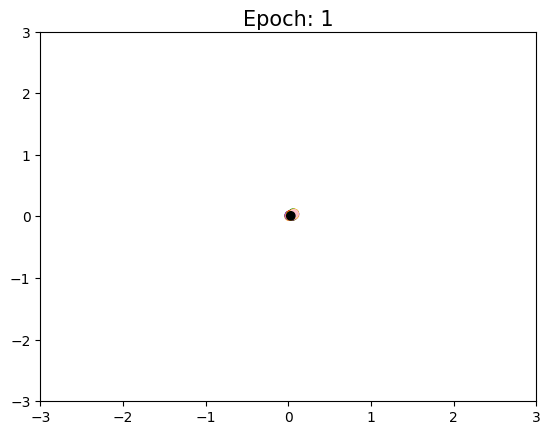

In [6]:
import matplotlib.animation as animation
import itertools

np.random.seed(42)
frames = D_interp.shape[0]
L_c = []
for l in L: L_c.append([int(x) for x in l])

x = np.arange(frames)
y = np.sin(x)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black', 'gold', 'pink']

centroids = np.zeros((frames, len(data_all.classes), 2))
for f in range(frames):
    for i, c in enumerate(data_all.classes):
        centroids[f, i, :] = np.median(D_interp[f, L[i] == i, :], axis=0)

fig, ax = plt.subplots()
s = ax.scatter([], [])
t = ax.text(0, 3.1, 'Start', ha='center', fontsize=15)

lines = []
scatters = []
for i in range(len(data_all.classes)):
    line, = ax.plot([], [], c=colors[i])
    lines.append(line)
    s = ax.scatter([], [], c=colors[i])
    scatters.append(s)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

#leg = ax.legend(colors)
line, ax.plot()

c_i = [colors[l] for l in L_c[0]]

def update(i):
    print(f"\r{100 * (i + 1) / frames}", end='')
    t.set_text(f"Epoch: {int(i // (D_interp.shape[0] / len(D)) + 1)}")
    for j, _ in enumerate(lines):
        lines[j].set_xdata(centroids[:i, j, 0])
        lines[j].set_ydata(centroids[:i, j, 1])
        lines[j].set_alpha(0.15)
        #lines[j].set_legend(data_all.classes[j])
    s.set_offsets(np.column_stack([D_interp[i, :, 0], D_interp[i, :, 1]]))
    s.set_facecolors(c_i)
    
        
ani = animation.FuncAnimation(fig, update, frames=frames, interval=10)
ani.save('set.gif', writer='pillow')

In [ ]:
model.eval()

data_mapped = np.zeros((len(data_all), 2))
labels_mapped = np.zeros(len(data_all))

idx = 0
for i, blob in enumerate(train_loader):
    with torch.no_grad():
        data, labels = [x.to(device).float() for x in blob]
        B = data.shape[0]
        dm = model(data)
        labels = torch.argmax(labels, dim=1).cpu().numpy()
        dm = (dm).cpu().numpy()
        labels_mapped[idx: idx + B] = labels
        data_mapped[idx: idx + B, :] = dm
        idx += B

for l in np.unique(labels_mapped):
    plt.scatter(data_mapped[labels_mapped == l, 0], data_mapped[labels_mapped==l, 1], label=data_all.classes[int(l)] + 'train')

In [ ]:
data_mapped = np.zeros((len(data_all), 2))
labels_mapped = np.zeros(len(data_all))

idx = 0
for i, blob in enumerate(valid_loader):
    with torch.no_grad():
        data, labels = [x.to(device).float() for x in blob]
        B = data.shape[0]
        dm = model(data)
        labels = torch.argmax(labels, dim=1).cpu().numpy()
        dm = (dm).cpu().numpy()
        labels_mapped[idx: idx + B] = labels
        data_mapped[idx: idx + B, :] = dm
        idx += B


for l in np.unique(labels_mapped):
    plt.scatter(data_mapped[labels_mapped == l, 0], data_mapped[labels_mapped==l, 1], label=data_all.classes[int(l)] + ' valid')
plt.legend(bbox_to_anchor=(1.04, 1), loc="center left")
plt.show()